<a href="https://colab.research.google.com/github/valdesius/Decision-tree/blob/main/2_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

full_df = pd.read_csv('cardio_train.csv', sep=';')
full_df['age'] = round(full_df['age'] / 365)

features = ['age', 'ap_hi']
target = 'cardio'

df = full_df[features + [target]]
df = df.head(5)

df.head()

,age,ap_hi,cardio
0,50.0,110,0
1,55.0,140,1
2,52.0,130,1
3,48.0,150,1
4,48.0,100,0


**Создаем класс узла с атрибутами:**
* ссылка на правый дочерний узел
* ссылка на левый дочерний узел
* среднеквадратичная ошибка для данного узла
* количество обучающих примеров
* значение, которое предсказывает данный узел
* индекс признака, по которому происходит разделение в данном узле
* пороговое значение, по которому происходит разделение в данном узле

In [ ]:
class Node:
    def __init__(self, left=None, right=None, gini=None, samples=None, value=None, feature=None, threshold=None):
        self.left = left
        self.right = right
        self.gini = gini
        self.samples = samples
        self.value = value
        self.feature = feature
        self.threshold = threshold

**Индекс Джини**

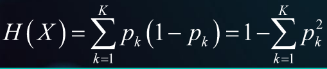

In [ ]:
import numpy as np

def gini(y):
    _, counts = np.unique(y, return_counts=True)
    pk = counts / len(y)
    return 1 - np.sum(pk ** 2)

**Информационный выигрыш**

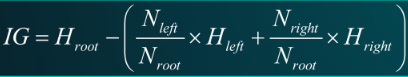

In [ ]:
def information_gain(y_root, y_left, y_right):
    gini_root = gini(y_root)
    gini_left = gini(y_left)
    gini_right = gini(y_right)

    n_root = len(y_root)
    n_left = len(y_left)
    n_right = len(y_right)

    ig = gini_root - ((n_left / n_root) * gini_left + (n_right / n_root) * gini_right)
    return ig

**Пороги разбиения**. Сначала нужно отсортировать значения признака по возрастанию, а потом берем среднее между соседними значениями

In [ ]:
def calculate_thresholds(df, feature):
    df_sorted = df.sort_values(by=feature)
    values = df_sorted[feature].values
    thresholds = [(values[i] + values[i + 1]) / 2 for i in range(len(values) - 1)]
    return thresholds

*Информационный выигрыш для всех возможных порогов разбиения для одного признака*

In [ ]:
def calculate_information_gain(df, feature, thresholds):
    gains = []
    for threshold in thresholds:
        left_mask = df[feature] <= threshold
        right_mask = df[feature] > threshold

        y_root = df[target].values
        y_left = df[left_mask][target].values
        y_right = df[right_mask][target].values

        ig = information_gain(y_root, y_left, y_right)
        gains.append(ig)

    return gains

```
def create_node(df, features)
```выбирает лучший признак и порог для разбиения данных, а затем создает узел с этими параметрами. Если нет подходящего признака для разбиения, функция создает *листовой узел*

In [ ]:
def create_node(df, features):
    best_feature = None
    best_threshold = None
    max_gain = -np.inf

    for feature in features:
        thresholds = calculate_thresholds(df, feature)
        if len(thresholds) == 0:
            continue
        gains = calculate_information_gain(df, feature, thresholds)
        max_gain_feature = max(gains)

        if max_gain_feature > max_gain:
            max_gain = max_gain_feature
            best_feature = feature
            best_threshold = thresholds[gains.index(max_gain_feature)]

    if best_feature is None:
        y_root = df[target].values
        gini_root = gini(y_root)
        samples_root = len(y_root)
        value_root = np.bincount(y_root).argmax()

        return Node(
            gini=gini_root,
            samples=samples_root,
            value=value_root
        ), None, None

    left_mask = df[best_feature] <= best_threshold
    right_mask = df[best_feature] > best_threshold

    y_root = df[target].values
    y_left = df[left_mask][target].values
    y_right = df[right_mask][target].values

    gini_root = gini(y_root)
    samples_root = len(y_root)
    value_root = np.bincount(y_root).argmax()

    node = Node(
        gini=gini_root,
        samples=samples_root,
        value=value_root,
        feature=best_feature,
        threshold=best_threshold
    )

    return node, left_mask, right_mask

**Рекурсивно строим дерево решений**

In [ ]:
def build_tree(df, features, depth=0, max_depth=5):
    if depth >= max_depth:
        y_root = df[target].values
        gini_root = gini(y_root)
        samples_root = len(y_root)
        value_root = np.bincount(y_root).argmax()
        return Node(
            gini=gini_root,
            samples=samples_root,
            value=value_root
        )

    node, left_mask, right_mask = create_node(df, features)

    if left_mask is not None:
        left_df = df[left_mask]
        node.left = build_tree(left_df, features, depth + 1, max_depth)

    if right_mask is not None:
        right_df = df[right_mask]
        node.right = build_tree(right_df, features, depth + 1, max_depth)

    return node


**Строим графически дерево**

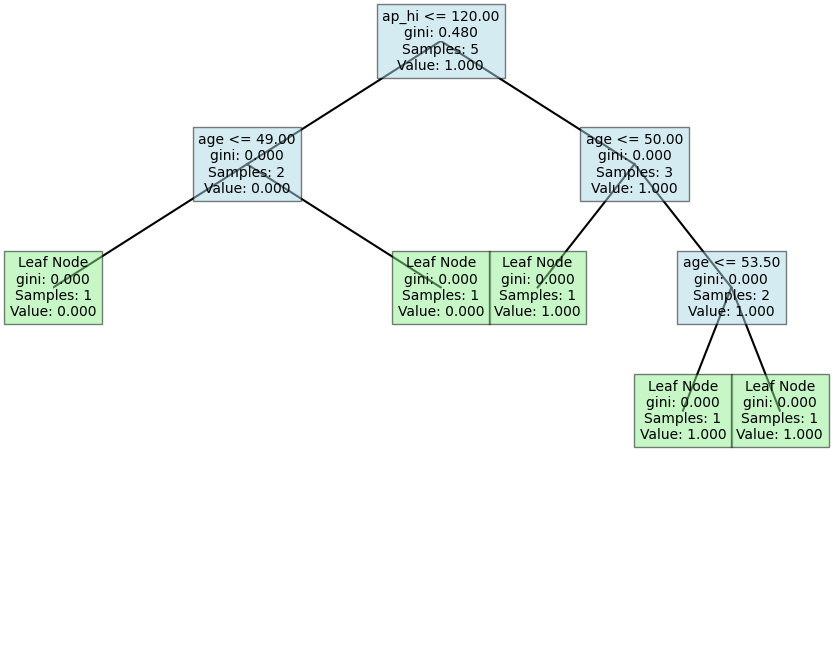

In [ ]:
def plot_custom_tree(node, ax, x, y, dx, dy, features):
    if node is not None:
        if node.feature is not None:
            ax.text(x, y, f"{node.feature} <= {node.threshold:.2f}\ngini: {node.gini:.3f}\nSamples: {node.samples}\nValue: {node.value:.3f}",
                    bbox=dict(facecolor='lightblue', alpha=0.5),
                    horizontalalignment='center',
                    verticalalignment='center')
        else:
            ax.text(x, y, f"Leaf Node\ngini: {node.gini:.3f}\nSamples: {node.samples}\nValue: {node.value:.3f}",
                    bbox=dict(facecolor='lightgreen', alpha=0.5),
                    horizontalalignment='center',
                    verticalalignment='center')

        if node.left is not None:
            ax.plot([x, x - dx], [y, y - dy], 'k-')
            plot_custom_tree(node.left, ax, x - dx, y - dy, dx, dy, features)

        if node.right is not None:
            ax.plot([x, x + dx], [y, y - dy], 'k-')
            plot_custom_tree(node.right, ax, x + dx, y - dy, dx / 2, dy, features)

import matplotlib.pyplot as plt

root = build_tree(df, features, max_depth=3)

fig, ax = plt.subplots(figsize=(10, 8))
plot_custom_tree(root, ax, 0, 1, 0.5, 0.2, features)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.show()


# Модель DecisionTreeClassifier

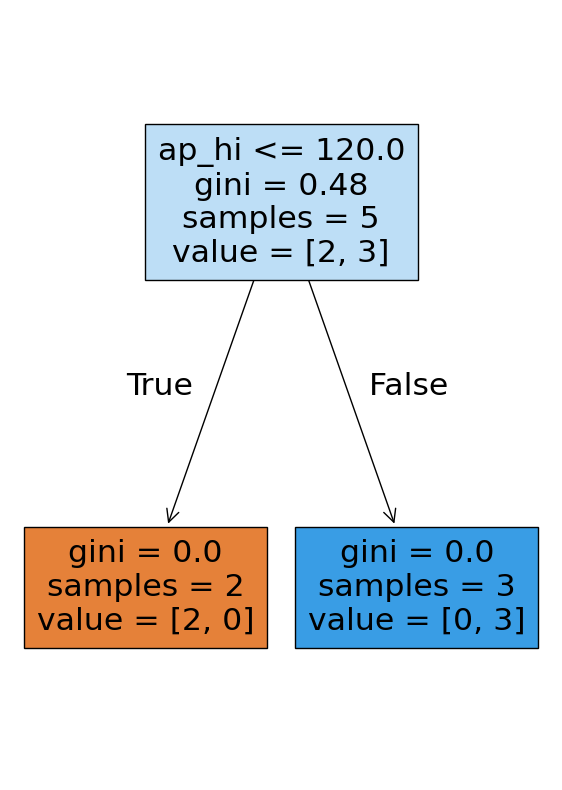

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X_selected = df[features]
y_selected = df[target]

tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_selected, y_selected)

plt.figure(figsize=(7, 10))
plot_tree(tree, feature_names=features, filled=True)
plt.show()
